In [1]:
import cirq
import matplotlib.pyplot as plt

After seeing how the QFT works and how it can be implemented efficiently, we want to briefly discuss an application of the QFT, namely the phase estimation.
Reading Ch.7.1, arXiv:quant-ph/9511026

The scenario is the following, we are given a unitary operator $U$ and an eigenvector $|\psi\rangle$ corresponding to an unknown eigenvalue $\lambda$. Our task is to compute (approximate) $\lambda$.
For this, we, of course, want to use the QFT. To do so we first notice that since $U$ is unitary we can write $\lambda = e^{2\pi i \phi}$, with $\phi \in [0,1)$.
Let's assume for a moment that we know $\phi$ can be written exact;y with n bits ($\phi = 0.\phi_1\phi_2...\phi_n$), then the phase estimation algoritm becomes clear:
\begin{theorem}
The phase can be calculated (estimated with high probability in the case where $\phi$ can not be written with n bits) Let $N = 2^n$

1. Start with $|\psi_1\rangle = |0\rangle^{n}|\psi\rangle$
2. Apply $H^{\otimes n} \otimes I$ to $|\psi_1\rangle$ giving $|\psi_2\rangle =\frac{1}{2^{n/2}}\sum^{N-1}_j|j\rangle|\psi\rangle$ 
3. Apply $|\psi_3\rangle = \tilde{U}|\psi_2\rangle = {2^{-n/2}}\sum^{N-1}_j|j\rangle U^j |\psi\rangle = {2^{-n/2}}\sum^{N-1}_j|j\rangle e^{2\pi i \phi j} |\psi\rangle = {2^{-n/2}}\sum^{N-1}_je^{2\pi i (2^n \phi) j/2^n} |j\rangle |\psi\rangle = \mathrm{QFT}|2^n\phi\rangle |\psi\rangle$
4. Apply $|\psi_4\rangle =(\mathrm{QFT}^{-1}_{2^N} \otimes I)|\psi_3\rangle = |2^n\phi\rangle |\psi\rangle$ and measure the first n-qubits
\end{theorem}
In case the phase can not be written precisely with $n$ bits, the algorithm will return $\hat{x}$, such that ${\hat{x}}/2^n$ is the closest integer multiple of $1/2^n$ to $\omega$ with probability $\frac{4}{\pi^2}$. See for example 7.1.1 for a detailed discussion.

We are now going to implement this algorithm for two cases.
1. the almost trivial case where U = Z and we are given $(|0\rangle)|1\rangle$ (which has eigenvalue $1, \phi = 0.0$ ($-1,\phi = 1/2$ corresponding to $\phi =0.1$ in binary)) 
2. The slightly more Interesting case of a phase gate $R_\phi$, here we can also play with the number of bits in the first register

In [2]:
def phase_est_Z(one = True):
    c = cirq.Circuit()
    #only need two qubits
    q = cirq.LineQubit.range(2)
    # apply H to first qubit 
    c.append([cirq.H(q[0])])
    #bring second into eigenstate |1> 
    if one == True:
        c.append([cirq.X(q[1])])
    #apply \tilde{U}=cU
    c.append(cirq.CZ(q[0],q[1]))
    #c.append(cirq.Z(q[1]))
    #apply inverse qft (see 5. for implementation of qft)
    c.append(cirq.qft(q[0])**-1)
    #measure first register
    c.append(cirq.ops.measure(q[0]))
    return c
    

In [3]:
phase_est_Z()

0: ───H───@───qft^-1───M───
          │
1: ───X───@────────────────

In [4]:
s=cirq.Simulator()
c =phase_est_Z(True)

In [5]:
# eigenvalue -1 so we expect phase of \pi which corresponds to \phi =1 
s.simulate(c)

measurements: 0=1
output vector: |11⟩

In [6]:
# eigenvalue 1 so we expect phase of 0 which corresponds to \phi =0
s=cirq.Simulator()
c =phase_est_Z(False)

In [7]:
s.simulate(c)

measurements: 0=0
output vector: |00⟩

Let us now turn to the more interesting case, where we will estimate the phase of 
\begin{equation}
R_\phi = \begin{bmatrix} 1 &0 \\ 0 & e^{2\pi i \phi} 
\end{bmatrix}= Z^{2\phi}
\end{equation}
This can now be implemented in a straightforward manner using controlled $Z$ gates.
We want to have the follwoing unitary transformation
\begin{equation}
\tilde{U}|j\rangle|\psi\rangle  =|j\rangle U^j |\psi\rangle, 
\end{equation}
where we understand $j$ as the integer corresponding to it's binary representation (e.g. $3 = 1*2^1+1*2^0 = 11$) hence to every qubit of the register (numbered $i=0,1,...n-1$) we assign the correspoding controlled gate $cZ^{2^{n-i}}= cR^{2^{n-i-1}}$. It should become now clear, that for every number we will get the right number of $U$. To demonstrate this let's stick with our example $3 = 1*2^1+1*2^0 = 11$. If our rgeister is in the state $|11\rangle$ we will apply $R^{2^{2-0-1}}R^{2^{2-1-1}} =R^{2^{1}}R^{2^{0}}= R^3 $.

In [12]:
def phase_est_R_circuit(n, phi, one = True):
    c = cirq.Circuit()
    #only need two qubits
    q = cirq.LineQubit.range(n+1)
    # apply H to first qubit 
    c.append([cirq.H(q[i]) for i in range(n)])
    #bring second into eigenstate |1> 
    if one == True:
        c.append([cirq.X(q[n])])
    #apply \tilde{U} see text for explanation
    c.append([(cirq.Z(q[n])**(phi*(2**(n-i)))).controlled_by(q[i]) for i in range(n)])
    #apply inverse qft (see 5. for implementation of qft)
    c.append(cirq.qft(*[q[i] for i in range(n)])**-1)
    #measure first register
    c.append([cirq.ops.measure(*q[0:n], key='first_reg')])
    return c
    

In [13]:
s=cirq.Simulator()
c = phase_est_R_circuit(3,3/8,True)
c

0: ───H───@───────────────────qft^-1───M('first_reg')───
          │                   │        │
1: ───H───┼───@───────────────#2───────M────────────────
          │   │               │        │
2: ───H───┼───┼──────@────────#3───────M────────────────
          │   │      │
3: ───X───Z───S^-1───Z^0.75─────────────────────────────

In [14]:
def phase_est_R(n ,phi, one =True, n_measurements = 100):
    s=cirq.Simulator()
    c = phase_est_R_circuit(n, phi, True)
    measured = []
    for i in range(n_measurements):
        m = s.simulate(c)
        x = sum([2**(-i-1)*m.measurements['first_reg'][i] for i in range(n)])
        measured.append(x)
    estimate = max(set(measured), key = measured.count)
    return measured, estimate

0.375

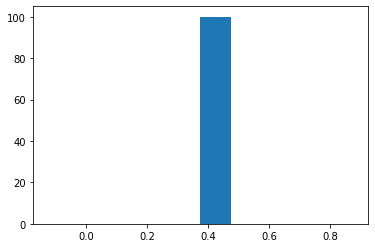

In [15]:
#3/8 = 1*2^-1+0*2^-2*1+1*2^-3 so can be represented with 3 bits
x = phase_est_R(3,3/8,True)
plt.hist(x[0])
x[1]

0.375

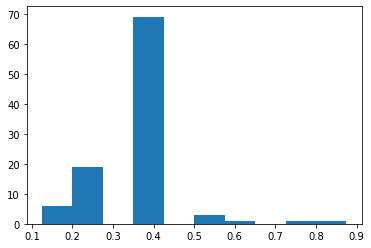

In [245]:
#1/3 can't be represented with finite number of bits
x = phase_est_R(3,1/3,True)
plt.hist(x[0])
x[1]

As we see we get the closest estimate to $1/3$ that can be represented with the number of bits.

Let's see how the results improve with increasing number of bits $n$ 

0.3330078125

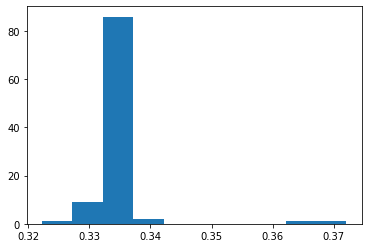

In [248]:
x = phase_est_R(10,1/3,True)
plt.hist(x[0])
x[1]

0.333251953125

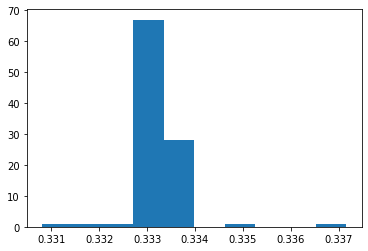

In [249]:
x = phase_est_R(12,1/3,True)
plt.hist(x[0])
x[1]

0.333343505859375

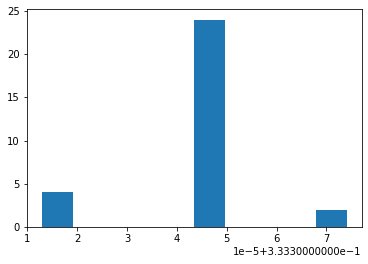

In [251]:
x = phase_est_R(15,1/3,True,  n_measurements = 30)
plt.hist(x[0])
x[1]